## 逻辑回归
**学习目标**：
- 把之前构建的加州房价中位数预测模型重构为判别房价高低的二元分类模型。
- 比较逻辑回归和线性回归解决二元分类问题的有效性。

### 把问题构建为二元分类问题
我们之前的模型的目标是预测连续值标签```median_house_value```，我们可以对此特征设置一个阈值来创建一个二值化的或者布尔值标签。

我们的模型功能变成了给定一个地方的住房区域的相关特征判定该住房的房价是否高昂。

我们假定分类阈值为房价的75%位数(约265000)，高于此阈值，房价标记为1(表示**高昂**)，否则标记为0(表示**不高昂**)

## 设置
加载加州住房数据集。

In [1]:
from __future__ import print_function

import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_df = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_train.csv",
                                   sep=',')
california_housing_df = california_housing_df.reindex(np.random.permutation(california_housing_df.index))

/Users/kevin/.virtualenvs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# 预处理特征
def preprocess_features(california_housing_df):
    """预处理房价的DataFrame，准备输入特征,添加人为特征
    Args:
        california_housing_df: 包含加州房价数据的df
    Returns:
        包含处理后特征的DataFrame
    """
    selected_features = california_housing_df[["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
    processed_features = selected_features.copy()
    # 创建额外的特征
    processed_features["rooms_per_person"] = (california_housing_df["total_rooms"] / california_housing_df["population"])
    return processed_features

# 预处理目标，添加二值标签(房价是否高昂)作为目标
def preprocess_targets(california_housing_df):
    """从加州房价DataFrame准备目标特征，即标签
    Args:
        california_housing_dataframe: 包含加州房价数据的df
    Returns:
        包含目标标签的df
    """
    # 分类阈值
    value_threshold = 265000
    output_targets = pd.DataFrame()
    # 使用astype把布尔值转换为二值
    output_targets["median_house_value_is_high"] = (california_housing_df["median_house_value"] > value_threshold).astype(float)
    return output_targets


In [9]:
# 选择前12000/17000用于训练
training_examples = preprocess_features(california_housing_df.head(12000))
training_targets = preprocess_targets(california_housing_df.head(12000))

# 选择最后的5000用于验证
validation_examples = preprocess_features(california_housing_df.tail(5000))
validation_targets = preprocess_targets(california_housing_df.tail(5000))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2643.2,538.8,1428.6,501.0,3.9,2.0
std,2.1,2.0,12.6,2193.5,424.5,1157.7,388.0,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1461.0,295.0,783.0,280.0,2.6,1.5
50%,34.2,-118.5,29.0,2118.0,433.0,1163.0,408.0,3.6,1.9
75%,37.7,-118.0,37.0,3139.2,649.0,1715.0,605.0,4.8,2.3
max,42.0,-114.3,52.0,30405.0,4957.0,35682.0,4769.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.6,2644.7,540.8,1431.8,501.7,3.9,2.0
std,2.1,2.0,12.5,2147.2,414.2,1123.9,376.1,1.9,1.2
min,32.5,-124.3,2.0,18.0,3.0,8.0,4.0,0.5,0.1
25%,33.9,-121.7,18.0,1465.0,302.0,806.8,285.0,2.6,1.5
50%,34.2,-118.5,29.0,2153.0,437.0,1177.0,411.0,3.5,1.9
75%,37.7,-118.0,37.0,3171.2,648.0,1740.2,606.0,4.7,2.3
max,41.9,-114.6,52.0,37937.0,6445.0,28566.0,6082.0,15.0,52.0


Training targets summary:


,median_house_value_is_high
count,12000.0
mean,0.3
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


Validation targets summary:


,median_house_value_is_high
count,5000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


In [10]:
def my_input_fn(features, targets, batch_size=1,shuffle=True, num_epochs=None):
    """使用多个特征训练一个线性回归器
    Args:
        features: 特征的DataFrame
        targets: 目标的DataFrame
        batch_size: 传递给模型的批大小
        shuffle: 是否打乱数据
        num_epochs: 数据重复的epochs数
    Returns:
        下一批数据元组(features, labels)
    """
    # 转换DataFrame到numpy数组
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    # 构建数据集
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # 打乱数据
    if shuffle:
        ds = ds.shuffle(10000)
        
    # 返回下一批数据
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [11]:
def construct_feature_columns(input_features):
    """构建特征列
    Args:
        input_features: 数值特征的名字
    Returns:
        特征列集
    """
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

In [12]:
def train_linear_regressor_model(learning_rate, 
                steps, 
                batch_size, 
                training_examples, 
                training_targets, 
                validation_examples, 
                validation_targets):
    """使用多个特征训练一个线性回归模型
    """
    periods = 10
    steps_per_period = steps / periods
    
    # 定义优化器
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    # 创建一个线性回归器
    linear_regressor = tf.estimator.LinearRegressor(feature_columns=construct_feature_columns(training_examples), 
                                                    optimizer=my_optimizer)
    
    # 创建输入函数
    training_input_fn = lambda: my_input_fn(training_examples,training_targets["median_house_value_is_high"], batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value_is_high"], num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["median_house_value_is_high"], num_epochs=1, shuffle=False)
    
    # 训练模型，并在每个周期输出loss
    print("Start training...")
    print("RMSE (on training data): ")
    training_rmse = []
    validation_rmse = []
    for period in range(0, periods):
        linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period)
        
        # 计算预测
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item["predictions"][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item["predictions"][0] for item in validation_predictions])
        
        # 计算训练和验证的损失
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        
        # 输出结果
        print("period %02d : %.2f" % (period, training_root_mean_squared_error))
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished!")
    
    # 损失随周期变化图
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error via Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validaiton")
    plt.legend()
    
    return linear_regressor

Start training...
RMSE (on training data): 
period 00 : 0.45
period 01 : 0.45
period 02 : 0.45
period 03 : 0.45
period 04 : 0.45
period 05 : 0.44
period 06 : 0.45
period 07 : 0.45
period 08 : 0.44
period 09 : 0.44
Model training finished!


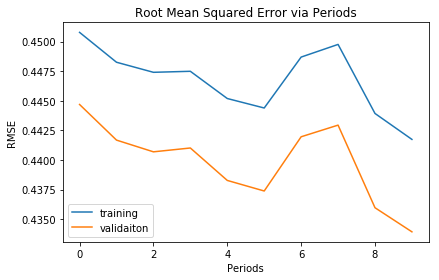

In [14]:
linear_regressor = train_linear_regressor_model(learning_rate=0.000001, 
                steps=200, 
                batch_size=20,
                training_examples=training_examples, 
                training_targets=training_targets,
               validation_examples=validation_examples,
               validation_targets=validation_targets)

### 任务1. 我们可以计算这些预测的对数损失吗？
检查预测，确定是否可以使用它们来计算对数损失函数。
LinearRegressor使用的是L2损失，在把输出解读为概率时，并不能很好的惩罚错误分类。例如，对于概率分别为0.9和0.9999的负分类样本是否被分类为正样本，两者的差异应该也很大，但L2损失不会明显区分这种差异。
使用对数损失函数对这些「置信错误」的惩罚力度更大：
$$LogLoss = \sum_{(x,y)\in{D}}{-y\cdot{log(y_{pred})-(1-y)\cdot{log(1-y_{pred})}}}$$

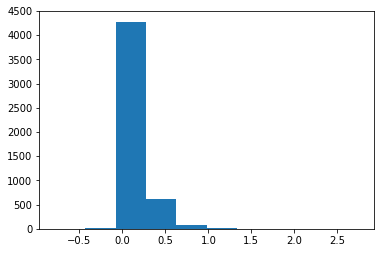

In [16]:

predict_validation_input_fn = lambda: my_input_fn(validation_examples,
                                                 validation_targets["median_house_value_is_high"],
                                                 num_epochs=1,
                                                 shuffle=False)
validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
_ = plt.hist(validation_predictions)

### 任务2. 训练逻辑回归模型并计算验证集的对数损失函数
我们使用LinearClassifier替换即可。

我们可以通过返回的字典中的predictions["probabilities"]键，来获取实值的预测概率。

In [27]:
def train_linear_classifier_model(learning_rate, 
                steps, 
                batch_size, 
                training_examples, 
                training_targets, 
                validation_examples, 
                validation_targets):
    """使用多个特征训练一个线性回归模型
    """
    periods = 10
    steps_per_period = steps / periods
    
    # 定义优化器
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    # 创建一个线性回归器
    linear_regressor = tf.estimator.LinearClassifier(feature_columns=construct_feature_columns(training_examples), 
                                                    optimizer=my_optimizer)
    
    # 创建输入函数
    training_input_fn = lambda: my_input_fn(training_examples,training_targets["median_house_value_is_high"], batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value_is_high"], num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["median_house_value_is_high"], num_epochs=1, shuffle=False)
    
    # 训练模型，并在每个周期输出loss
    print("Start training...")
    print("Log loss (on training data): ")
    training_rmse = []
    validation_rmse = []
    for period in range(0, periods):
        linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period)
        
        # 计算预测
        training_probabilities = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_probabilities = np.array([item["probabilities"] for item in training_probabilities])
        validation_probabilities = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_probabilities = np.array([item["probabilities"] for item in validation_probabilities])
        
        # 计算训练和验证的损失
        training_log_loss = metrics.log_loss(training_targets, training_probabilities)
        validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
        
        # 输出结果
        print("period %02d : %.2f" % (period, training_log_loss))
        training_rmse.append(training_log_loss)
        validation_rmse.append(validation_log_loss)
    print("Model training finished!")
    
    # 损失随周期变化图
    plt.ylabel("Log Loss")
    plt.xlabel("Periods")
    plt.title("Log Loss via Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validaiton")
    plt.legend()
    
    return linear_regressor

Start training...
Log loss (on training data): 
period 00 : 0.60
period 01 : 0.58
period 02 : 0.57
period 03 : 0.56
period 04 : 0.56
period 05 : 0.55
period 06 : 0.54
period 07 : 0.54
period 08 : 0.54
period 09 : 0.53
Model training finished!


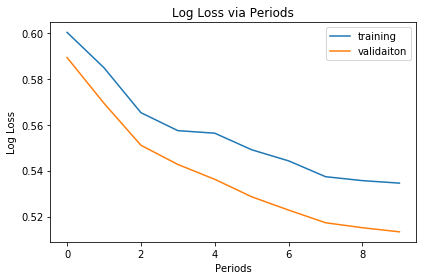

In [28]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000005,
    steps=500,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### 任务3. 计算准确率并绘制ROC曲线
分类时的常用的评价指标：模型准确率、ROC曲线、ROC曲线下面积(AUC)。

LinearClassifier.evaluate()为我们提供了方便的api计算这些指标。

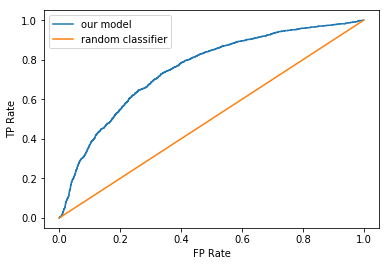

In [31]:
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
# 只获得正类的实值预测概率
validation_probabilities = np.array([item["probabilities"][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(validation_targets,
                                                                        validation_probabilities)
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)

提升模型性能和指标的可能的解决方案是，只要不过拟合，就可以训练更长的时间。

Start training...
Log loss (on training data): 
period 00 : 0.50
period 01 : 0.49
period 02 : 0.48
period 03 : 0.48
period 04 : 0.48
period 05 : 0.48
period 06 : 0.48
period 07 : 0.47
period 08 : 0.47
period 09 : 0.47
Model training finished!
AUC on the validation set: 0.82
Accuracy on the validation set: 0.79


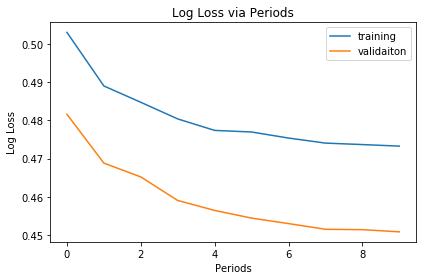

In [32]:

linear_classifier = train_linear_classifier_model(
    learning_rate=0.000003,
    steps=20000,
    batch_size=500,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])